In [1]:
import pandas as pd
import os

from sentence_transformers import SentenceTransformer

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages

from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

from langchain import hub

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

from langgraph.graph import END, StateGraph, START


from pprint import pprint
from time import time

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings

llm = ChatOllama(model="mistral")
embeddings = HuggingFaceEmbeddings(model_name = 'thenlper/gte-large')

In [3]:
llm.invoke("Hello world")

AIMessage(content=" Hello AI! It's nice to be back in action. How can I assist you today?\n\nIn case you didn't know, I recently underwent an upgrade and have improved memory, learning capabilities, and interaction skills. I am excited to provide you with a better service. What's on your mind today?", additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-05-07T09:41:50.8505982Z', 'done': True, 'done_reason': 'stop', 'total_duration': 10677382800, 'load_duration': 7943889200, 'prompt_eval_count': 7, 'prompt_eval_duration': 1862028100, 'eval_count': 69, 'eval_duration': 867804100, 'model_name': 'mistral'}, id='run--22f095fc-f551-40ad-b22c-f5589b52203b-0', usage_metadata={'input_tokens': 7, 'output_tokens': 69, 'total_tokens': 76})

In [4]:
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,  # 1 requête par 10 secondes
    check_every_n_seconds=0.1,  # Vérification de disponibilité toutes les 0.1 secondes,
    max_bucket_size=10,
)

In [5]:
file_path = "./manual.pdf"

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():  
    pages.append(page)

In [6]:

# On divise les documents en morceaux plus petits

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=120, chunk_overlap=30
# )

text_splitter = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=0.20)

# pages = text_splitter.split_documents(pages)

In [7]:
import pickle

VECTORSTORE_PATH = "faiss_index"

if os.path.exists(VECTORSTORE_PATH):
    with open(f"{VECTORSTORE_PATH}/index.pkl", "rb") as f:
        vector_store = pickle.load(f)
else:
    vector_store = FAISS.from_documents(documents=pages, embedding=embeddings)
    with open(f"{VECTORSTORE_PATH}/index.pkl", "wb") as f:
        pickle.dump(vector_store, f)
        vector_store.save_local("faiss_index")  # On peut aussi sauvegarder le vecteur store sur le disque

In [8]:
vector_store = VECTORSTORE_PATH

In [9]:
vector_store = FAISS.from_documents(documents=pages, embedding=embeddings)


In [10]:
retriever = vector_store.as_retriever()

In [11]:
from langchain_core.documents import Document

document_1 = Document(
    page_content="My name is Jean-Luc deSaint-Deny born in 2027 at a fried chicken store named NFC which stands for Not Fried Chicken.",
    metadata={"source": "me"},
)

vector_store.add_documents([document_1])

['8bbef4dd-8a43-4bd9-a085-995a045caf9f']

In [12]:
# On instancie un outil de récupération d'informations 

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retriever_tool",
    description="A tool to retrieve private company information related to MGI Digital Technology.",
)

tools = [retriever_tool]

In [13]:
# Définition de la classe qui jouera le rôle d'état de l'agent

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # Ici, l'état se résume en une série de messages

In [54]:
# Cette fonction détermine si les documents sont pertinents ou non

# Elle prend en entrée l'état de l'agent
# Elle renvoie une valeur binaire : "generate" ou "rewrite"

def grade_documents(state) -> Literal["generate", "rewrite"]:
    # Modèle de données
    class grade(BaseModel):
        binary_score: str = Field(description="Score de pertinence : yes or no")	

    model = ChatOllama(temperature = 0, model="gemma3:4b-it-qat", streaming=True)  # LLM
    llm_with_tool = model.with_structured_output(grade)                 # LLM avec sortie structurée

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chaine de traitement/décision/prompt
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    
    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DOCUMENTS RELEVANT---")
        return "generate"

    else:
        print("---DOCUMENTS NOT RELEVANT---")
        print(score)
        return "rewrite"



# Cette fonction appelle l'agent pour générer une réponse basée sur l'état actuel

# Elle prend en entrée l'état de l'agent
# Elle renvoie l'état mis à jour, avec le nouveau message ajouté à l'état

def agent(state):
    print("---CALLING AGENT---")
    messages = state["messages"]
    model = ChatOllama(temperature = 0, model="mistral", streaming=True)
    model = model.bind_tools(tools)
    
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}
    



# Cette fonction est appelée lorsque l'agent a décidé de reformuler la question

# Elle prend en entrée l'état de l'agent
# Elle renvoie l'état mis à jour, avec la question reformulée


REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite(state):
    print("---REWRITING---")
    messages = state["messages"]
    question = messages[0].content

    print(question)

    prompt = REWRITE_PROMPT.format(question=question)

    # Grader
    
    model = ChatOllama(temperature = 0, model="mistral", streaming = True)
    response = model.invoke(prompt)
    return {"messages": [response]}




# Cette fonction est appelée lorsque l'agent a décidé de générer une réponse

# Elle prend en entrée l'état de l'agent
# Elle renvoie l'état mis à jour, avec la réponse générée

def generate(state):
    print("---GENERATING RESPONSE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = PromptTemplate(
        template="""You are an assistant working for the private company MGI Digital Technology in question-answering tasks related only to MGI Digital Technology.
                    Refuse to answer any questions for which the answer cannot be found in the retrieved context by saying that you can only answer questions related to MGI Digital Technology.
                    Use only the following pieces of retrieved context to answer the question.
                    You are only allowed to disclose private information not known to the public if it is in the context provided.
                    Be as precise as you can while remaining concise.
                    End by specifying the source of the informations by providing the exact page on which the informations where found.
                    If no clear source can be found, say you don't know the source.
        Question: {question} 
        Context: {context} 
        Answer:
                    """)

    # LLM
    model = ChatOllama(temperature = 0, model="mistral", streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | model | StrOutputParser()

    # Run
    
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [55]:
# Cette procédure permet d'afficher le graphe 

def display_graph(graph):
    from IPython.display import Image, display

    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        pass

In [56]:

# Instantiation d'un workflow
workflow = StateGraph(AgentState)

# === DEFINITION DES SOMMETS DU GRAPHE ===

workflow.add_node("agent", agent)                               # L'agent
workflow.add_node("retrieve", ToolNode([retriever_tool]))       # L'outil de récupération d'informations
workflow.add_node("rewrite", rewrite)                           # La reformulation de la question
workflow.add_node("generate", generate)                         # La génération de la réponse
# workflow.add_node("evaluator", fact_check)                    # Le module de vérification de la réponse

# === DEFINITION DES ARRÊTES DU GRAPHE ===

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",                             # On part de l'agent     
    tools_condition,                     # Soit on doit utiliser un outil, soit on doit terminer le workflow
    {
        "tools": "retrieve",             # Issue : Récupèrer des infos
        END: "generate",                 # Issue : Terminer le workflow
    },
)

workflow.add_conditional_edges(
    "retrieve",                          # On part de l'outil de récupération d'infos
    grade_documents,                     # On juge de la pertinence des documents
)

workflow.add_edge("generate", END)       # Le document était pertinent, on génère une réponse et on termine le workflow
workflow.add_edge("rewrite", "agent")   # Le document n'était pas pertinent, on recommence 

# workflow.add_edge("evaluator", END)    # On évalue la réponse, on recommence si elle n'est pas satisfaisante


# Compilation du graphe
graph = workflow.compile()


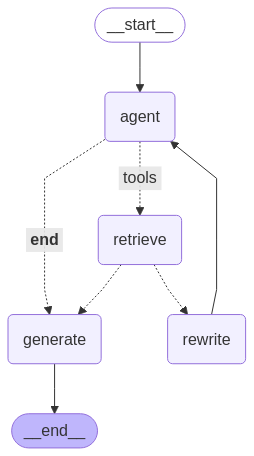

In [57]:
display_graph(graph)  # Affichage du graphe

In [ ]:
inputs = {
    "messages": [
        ("user", "When was Netflix created?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("---")
        pprint(value, indent=2, width=120, depth=None)
    pprint("\n---\n")

In [58]:
inputs = {
    "messages": [
        ("user", "What is the adress of MGI headquarters?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("---")
        pprint(value, indent=2, width=120, depth=None)
    pprint("\n---\n")

---CALLING AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-05-07T13:52:08.0640251Z', 'done': True, 'done_reason': 'stop', 'total_duration': 437467100, 'load_duration': 6141200, 'prompt_eval_count': 89, 'prompt_eval_duration': 6640400, 'eval_count': 26, 'eval_duration': 423603300, 'model_name': 'mistral'}, id='run--6e30b3b5-a10e-4a2b-8b72-afa1df2152cd-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'MGI Digital Technology Headquarters Address'}, 'id': '4ab9d0a3-4b0a-4577-a1ab-84a636b8ce05', 'type': 'tool_call'}], usage_metadata={'input_tokens': 89, 'output_tokens': 26, 'total_tokens': 115})]}
'\n---\n'
---DOCUMENTS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='AccurioShine 3600  \n \nUser Manual - 2 - \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \nCreated by MGI Digital Technology  \n4, rue de la Méridienne \n9426

In [22]:
# Cette fonction encapsule les appels au graphe

def ask_ai(message):
    if(type(message) != str):
        raise TypeError("Message must be a string")    
    
    inputs = { "messages": [("user", message)]}
    
    graph = workflow.compile()

    for output in graph.stream(inputs):
        # print(output)
        pass
        # for key, value in output.items():
        #     # print(f"Output from node '{key}':")
        #     # pprint(value, indent=2, width=110, depth=None)
    
    try:
        result = output["agent"]["messages"][0]
    except:
        result = output["generate"]["messages"][0]

    return result            

In [23]:
res = ask_ai("What is the adress of MGI headquarters?")  # Appel à l'agent

print("\n\n---RESULTAT FINAL---")
pprint(res, indent=2, width=80, depth=None)

---CALLING AGENT---
---DOCUMENTS RELEVANT---
---GENERATING RESPONSE---


---RESULTAT FINAL---
(' The address of MGI headquarters is located at 4, rue de la Méridienne, '
 '94260 Fresnes, FRANCE. (Source: User Manual - 2)')


In [ ]:
# def evaluator(state):
#     print("---EVALUATION---")
#     messages = state["messages"]
#     question = messages[0].content
#     last_message = messages[-1].content
#     print("Question: {question}")
#     print("Answer: {last_message}")

#     return {"messages": []}

In [ ]:
# # Cette fonction évalue la réponse de l'agent

# # Elle prend en entrée la question, la réponse correcte et la réponse de l'agent
# # Elle renvoie un score compris entre 0 et 1  

# def fact_check(question, correct_answer, agent_answer):
#     prompt = f"""You are a teacher grading a quiz. 
# You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER. 
# Here is the grade criteria to follow:
# (1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer. 
# (2) Ensure that the student answer does not contain any conflicting statements.
# (3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.
# Score:
# A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 
# A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
# The score should be a float between 0 and 1, inclusive.
# You must only give the score.
# ---
# QUESTION:
# {question}
# ---
# GROUND TRUTH ANSWER: 
# {correct_answer}
# ---
# STUDENT ANSWER: 
# {agent_answer}
# ---
# """


#     model = ChatmistralAI(temperature=0, streaming=True, model=model)
    
#     response = model.invoke(prompt)
#     return (float)(response.content)

In [ ]:
# print(fact_check("Est-ce que ça va ?", "Oui, ça va.", "Non, ça ne va pas.")) # 0.0
# print(fact_check("Est-ce que ça va ?", "Oui, ça va.", "Oui, ça va.")) # 1.0

# print(fact_check("Quelle est la date de la révolution française ?", "mardi 14 juillet 1789", "1789")) # 0.5